Sets up LB parameters and simulation geometry

In [1]:
using LatBo

mmHg = 133.3223684211
Npoints = 30, 30
δt, δx = 5e-4, 1e-3
μ₀ = 0.01sqrt(1./3.) * δt / δx
sim = lbgk(:D2Q9, Npoints, δt, δx; viscosity=4e-1, p₀=80.0 * mmHg, μ₀ = ones(2)μ₀)
Playground.initialize(sim.playground) do i, j
    coords = Float64[i, j]
    if j == 1 || j == Npoints[2] || i == 1 || i == Npoints[1]
        return Playground.SOLID
    else
        return Playground.FLUID
    end
end
sim.kernels[Playground.FLUID]

FluidKernel(SingleRelaxationTime{Float64}(0.625),[0x04=>NashZeroOrderPressure{Float64}([0.0,1.0],8.999342105266),0x02=>FluidStreaming(),0x03=>HalfWayBounceBack(),0x05=>NashZeroOrderPressure{Float64}([0.0,1.0],8.999342105266)])

Does actual computation, while keeping trac of total kinetic energy

In [2]:
kinetic = Float64[]
run!(sim, nsteps=60) do
    ν = velocity(sim)
    valid = !isnan(ν)
    push!(kinetic, 0.5sum(momentum(sim)[valid] .* ν[valid]))
end

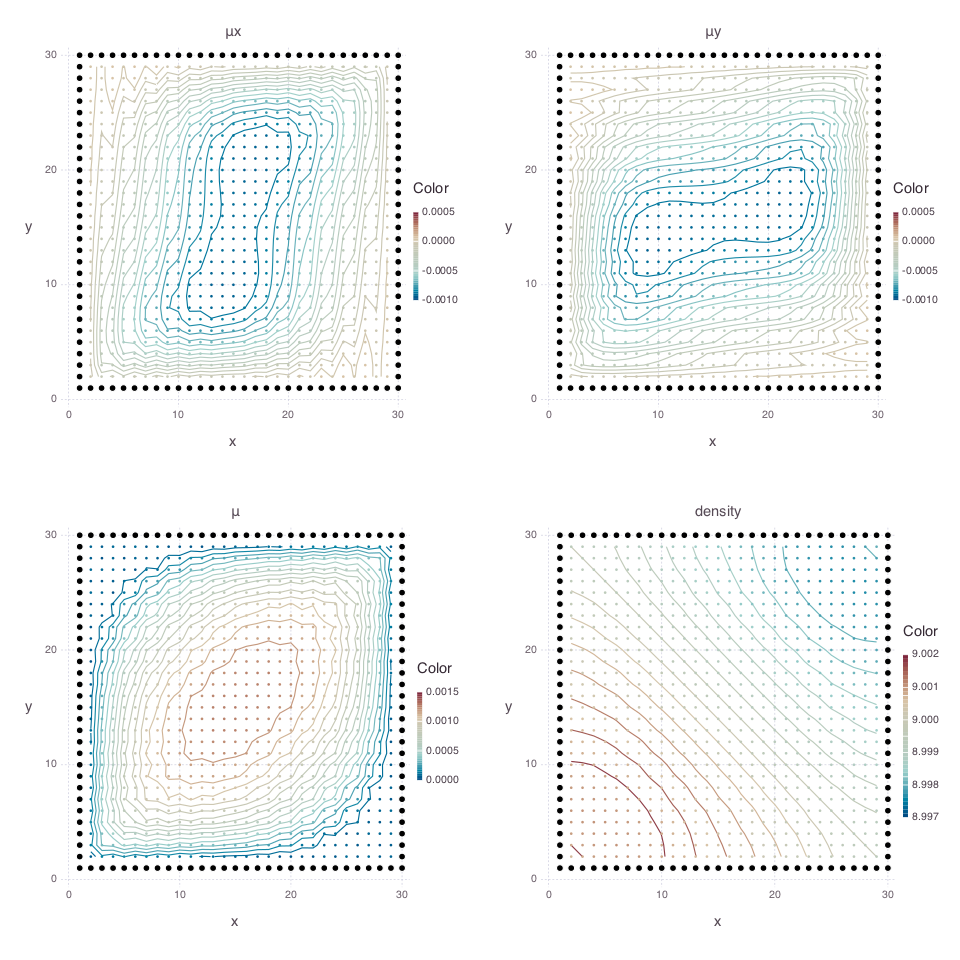

In [3]:
include(joinpath(Pkg.dir("LatBo"), "extras", "SimplePlot.jl"))
using Gadfly
width=5inch
set_default_plot_size(2width, 2width * float(Npoints[2])/float(Npoints[1]))

x = [gridcoords(sim.indexing, i)[1] for i = 1:length(sim.playground)]
y = [gridcoords(sim.indexing, i)[2] for i = 1:length(sim.playground)]
vstack(
  hstack(
    plot(:μx, sim, Theme(default_point_size=1pt, highlight_width=0pt)),
    plot(:μy, sim, Theme(default_point_size=1pt, highlight_width=0pt))
  ),
  hstack(
    plot(:μ, sim, Theme(default_point_size=1pt, highlight_width=0pt)),
    plot(:density, sim, Theme(default_point_size=1pt, highlight_width=0pt))
  )
)

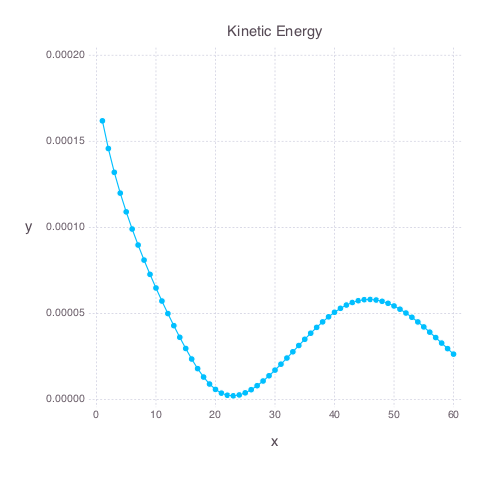

In [4]:
set_default_plot_size(width, width * float(Npoints[2])/float(Npoints[1]))
plot(x=collect(1:length(kinetic)), y=kinetic, Geom.line, Geom.point, Guide.Title("Kinetic Energy"))